In [95]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [96]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [97]:
train_dir = 'data/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [98]:
train_df

,filepaths,labels
0,data/train\angry\Training_10118481.jpg,angry
1,data/train\angry\Training_10120469.jpg,angry
2,data/train\angry\Training_10131352.jpg,angry
3,data/train\angry\Training_10161559.jpg,angry
4,data/train\angry\Training_1021836.jpg,angry
...,...,...
28704,data/train\surprise\Training_99916297.jpg,surprise
28705,data/train\surprise\Training_99924420.jpg,surprise
28706,data/train\surprise\Training_99937001.jpg,surprise
28707,data/train\surprise\Training_99951755.jpg,surprise


In [99]:
test_dir = 'data/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [100]:
test_df

,filepaths,labels
0,data/test\angry\PrivateTest_10131363.jpg,angry
1,data/test\angry\PrivateTest_10304478.jpg,angry
2,data/test\angry\PrivateTest_1054527.jpg,angry
3,data/test\angry\PrivateTest_10590091.jpg,angry
4,data/test\angry\PrivateTest_1109992.jpg,angry
...,...,...
7173,data/test\surprise\PublicTest_98089595.jpg,surprise
7174,data/test\surprise\PublicTest_98567249.jpg,surprise
7175,data/test\surprise\PublicTest_98972870.jpg,surprise
7176,data/test\surprise\PublicTest_99242645.jpg,surprise


In [101]:
train_df, valid_df = train_test_split(train_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [102]:
train_df

,filepaths,labels
22354,data/train\sad\Training_4071905.jpg,sad
4238,data/train\disgust\Training_62572176.jpg,disgust
2279,data/train\angry\Training_61879181.jpg,angry
15882,data/train\neutral\Training_12609029.jpg,neutral
4504,data/train\fear\Training_11790079.jpg,fear
...,...,...
28636,data/train\surprise\Training_98197769.jpg,surprise
17730,data/train\neutral\Training_45711010.jpg,neutral
28030,data/train\surprise\Training_79781970.jpg,surprise
15725,data/train\happy\Training_99764347.jpg,happy


In [103]:
valid_df

,filepaths,labels
25779,data/train\surprise\Training_16829753.jpg,surprise
21014,data/train\sad\Training_15822246.jpg,sad
27528,data/train\surprise\Training_66777416.jpg,surprise
2759,data/train\angry\Training_72696789.jpg,angry
23569,data/train\sad\Training_62945391.jpg,sad
...,...,...
17859,data/train\neutral\Training_48000156.jpg,neutral
10251,data/train\happy\Training_30925338.jpg,happy
16905,data/train\neutral\Training_30432338.jpg,neutral
23965,data/train\sad\Training_69982805.jpg,sad


In [104]:
# crobed image size
batch_size = 64
img_size = (48,48)
channels = 3
img_shape = (img_size[0], img_size[1], 1)

In [105]:
tr_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  # Góc xoay ảnh trong khoảng từ -10 đến +10 độ
        width_shift_range=0.1,  # Dịch chuyển chiều rộng ảnh trong khoảng từ -0.1 đến +0.1
        height_shift_range=0.1,  # Dịch chuyển chiều cao ảnh trong khoảng từ -0.1 đến +0.1
        shear_range=0.2,  # Góc cắt tỉa
        zoom_range=0.2,  # Phóng to hoặc thu nhỏ ảnh
        horizontal_flip=True,  # Lật ngang ảnh
        vertical_flip=False,  # Không lật dọc ảnh
        fill_mode='nearest' 
)
ts_gen = ImageDataGenerator(rescale=1./255)
train_generator = tr_gen.flow_from_dataframe(
        train_df,
        x_col= 'filepaths',
        y_col= 'labels',
        target_size=img_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle = True
)

validation_generator = tr_gen.flow_from_dataframe(
        valid_df,
        x_col= 'filepaths',
        y_col= 'labels',
        target_size=img_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle = True
)

test_generator = ts_gen.flow_from_dataframe(
        test_df,
        x_col= 'filepaths',
        y_col= 'labels',
        target_size=img_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle = True
)


Found 17225 validated image filenames belonging to 7 classes.
Found 11484 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


In [106]:
no_of_classes = 7
model = Sequential()
model.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=img_shape,
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
model.add(BatchNormalization(name='batchnorm_2'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.4, name='dropout_1'))

model.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )
)
model.add(BatchNormalization(name='batchnorm_4'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.4, name='dropout_2'))

model.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
model.add(BatchNormalization(name='batchnorm_6'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.5, name='dropout_3'))

model.add(Flatten(name='flatten'))
    
model.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
model.add(BatchNormalization(name='batchnorm_7'))

model.add(Dropout(0.6, name='dropout_4'))

model.add(
    Dense(
        no_of_classes,
        activation='softmax',
        name='out_layer'
    )
)

In [107]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [108]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [109]:
num_train = len(train_df)
num_val = len(valid_df)
batch_size = 64
num_epoch = 50

In [111]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
try:
    model_info = model.fit(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size,
        callbacks=callbacks
    )
except Exception as e:
    print(e)

Epoch 1/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 249s 911ms/step - accuracy: 0.1948 - loss: 2.6132 - val_accuracy: 0.2950 - val_loss: 1.7676 - learning_rate: 0.0010
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.3438 - loss: 0.9583 - val_accuracy: 0.3214 - val_loss: 0.9184 - learning_rate: 0.0010
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 234s 867ms/step - accuracy: 0.2707 - loss: 1.8898 - val_accuracy: 0.3476 - val_loss: 1.6622 - learning_rate: 0.0010
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.3281 - loss: 0.8296 - val_accuracy: 0.3929 - val_loss: 0.8336 - learning_rate: 0.0010
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 243s 902ms/step - accuracy: 0.3343 - loss: 1.6937 - val_accuracy: 0.3694 - val_loss: 1.6104 - learning_rate: 0.0010
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - accuracy: 0.4219 - loss: 0.7506 - val_accuracy: 0.4286 - val_loss: 0.6674 - learning_rate: 0.0010
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 236s 876ms/step - accuracy: 0.

In [112]:
model.save('model.h5')

In [113]:
# Define needed variables
tr_acc = model_info.history['accuracy']
tr_loss = model_info.history['loss']
val_acc = model_info.history['val_accuracy']
val_loss = model_info.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

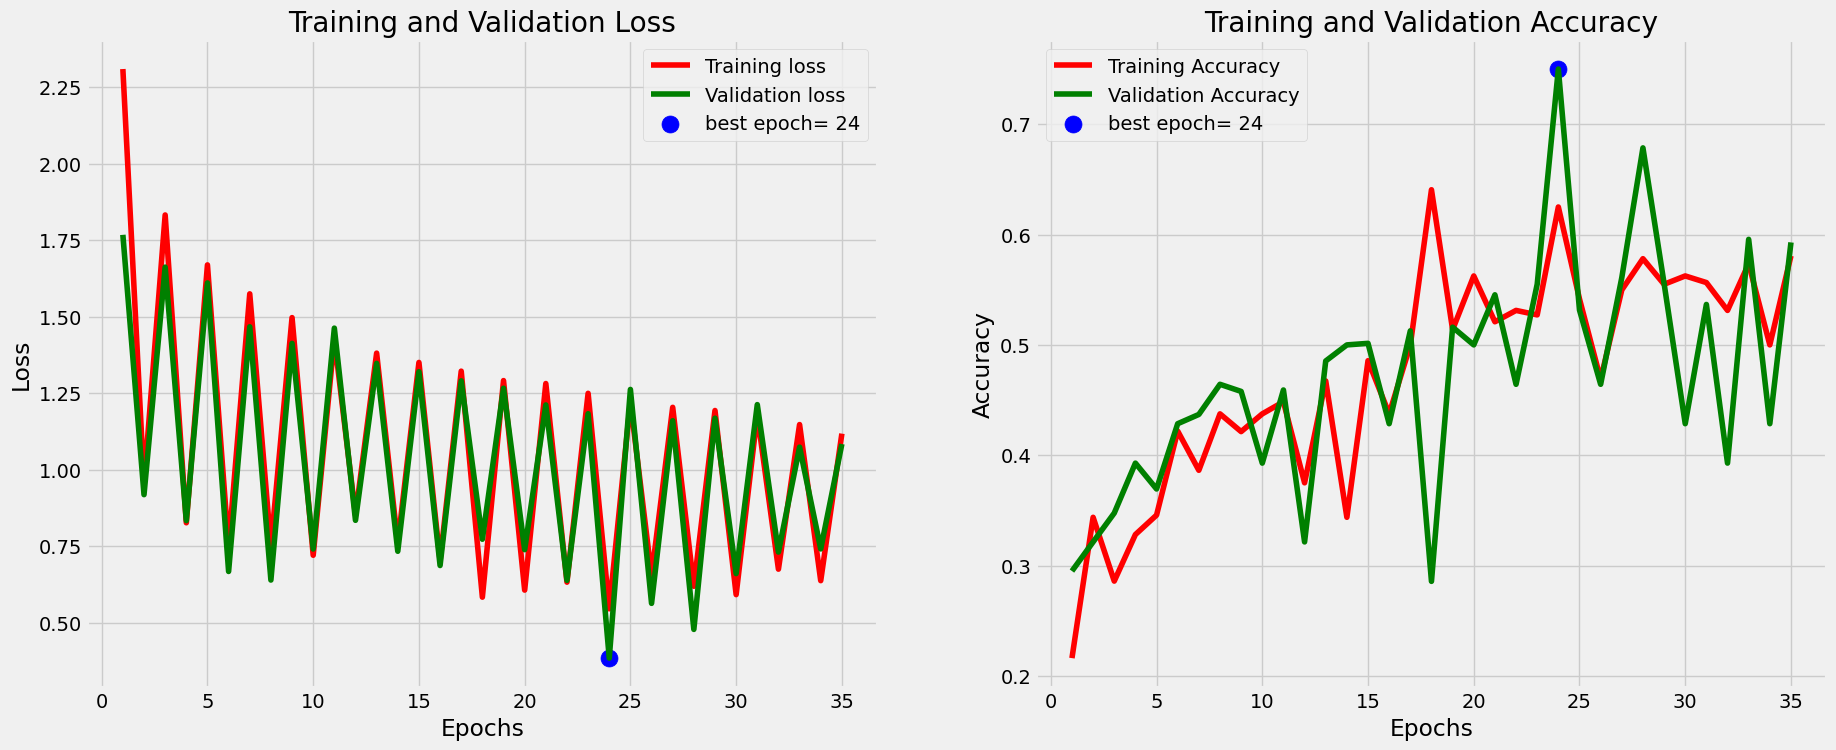

In [114]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [115]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model.evaluate(validation_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.5701 - loss: 1.1447
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.5387 - loss: 1.2094
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.5583 - loss: 1.1574
Train Loss:  1.1486045122146606
Train Accuracy:  0.5658827424049377
--------------------
Validation Loss:  1.1942145824432373
Validation Accuracy:  0.5504187941551208
--------------------
Test Loss:  1.156650424003601
Test Accuracy:  0.563466489315033


In [116]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step


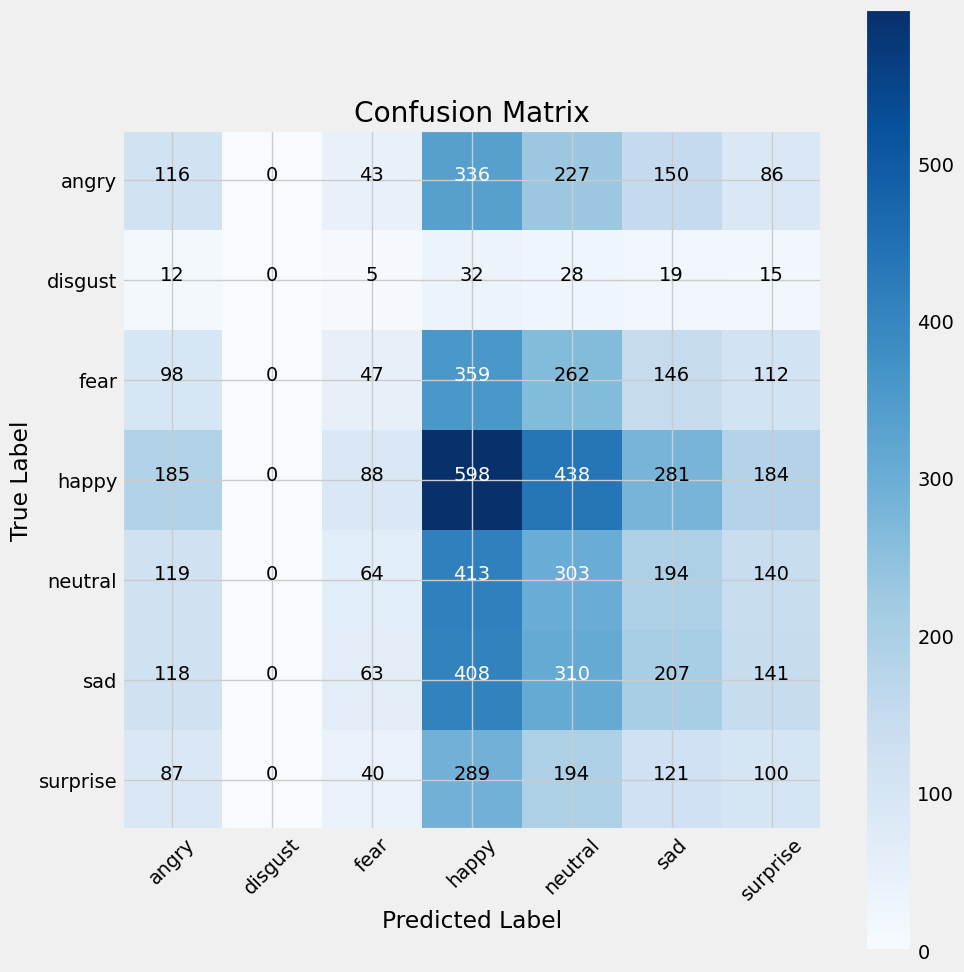

In [117]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [118]:
# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.16      0.12      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.05      0.07      1024
       happy       0.25      0.34      0.28      1774
     neutral       0.17      0.25      0.20      1233
         sad       0.19      0.17      0.18      1247
    surprise       0.13      0.12      0.12       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.19      0.18      7178

